In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')  # Ensure TF does not see GPU and grab all GPU memory.
tf.random.set_seed(42)  # For reproducibility.

from quantum_transformers.utils import plot_image
from quantum_transformers.datasets import get_quark_gluon_dataloaders

data_dir = '/global/cfs/cdirs/m4392/salcc/data'

2023-10-06 11:20:00.722789: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-06 11:20:00.722820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-06 11:20:00.722848: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-06 11:20:00.732651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 11:20:02.146263: W tensorflow/compiler/

In [2]:
qg_train_dataloader, qg_val_dataloader, qg_test_dataloader = get_quark_gluon_dataloaders(data_dir=data_dir)

q_one, g_one = None, None
q_avg, g_avg = None, None
q_n, g_n = 0, 0

for dataloader in [qg_train_dataloader, qg_val_dataloader, qg_test_dataloader]:
    for X, y in dataloader:
        X, y = np.squeeze(X), y[0]
        if y == 0:
            if q_avg is None:
                q_one = X.copy()
                q_avg = X.copy()
            else:
                q_avg += X.copy()
            q_n += 1
        else:
            if g_avg is None:
                g_one = X.copy()
                g_avg = X.copy()
            else:
                g_avg += X.copy()
            g_n += 1

q_avg /= q_n
g_avg /= g_n

Cardinalities (train, val, test): 714510 79390 139306


In [3]:
q_n, g_n

(466603, 466603)

In [4]:
def plot_image(images, filename=None):
    """Plots an image with one subplot per channel"""
    cmaps = ['Reds', 'Greens', 'Blues']

    plt.rcParams.update({'font.size': 16})

    num_channels = 3
    fig, axs = plt.subplots(len(images), num_channels + 1, figsize=((num_channels + 1) * 2.8, 2.8 * len(images)), sharey=True, sharex=True)
    for j, image in enumerate(images):
        for i, ax in enumerate(axs[j]):
            if i < num_channels:
                ax.imshow(np.log(np.abs(image[:, :, i]) + 1e-6), cmap=cmaps[i])
            else:
                image = np.log(np.abs(image) + 1e-6)
                # Global normalization
                # image = (image - image.min()) / (image.max() - image.min())
                # Per-channel normalization
                image = np.stack([(channel - channel.min()) / (channel.max() - channel.min()) for channel in image.transpose(2, 0, 1)]).transpose(1, 2, 0)
                ax.imshow(image)   
            if i == 0:
                ax.set_ylabel(r"$i\eta'$")
            if j == len(images) - 1:
                ax.set_xlabel(r"$i\varphi'$")
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

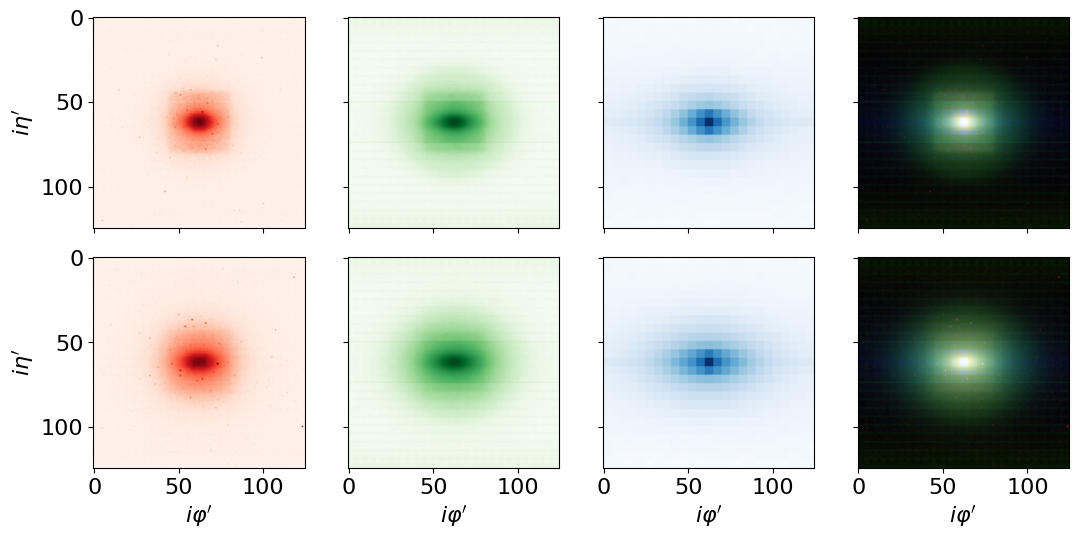

In [5]:
plot_image([q_avg, g_avg], 'avg.pdf')

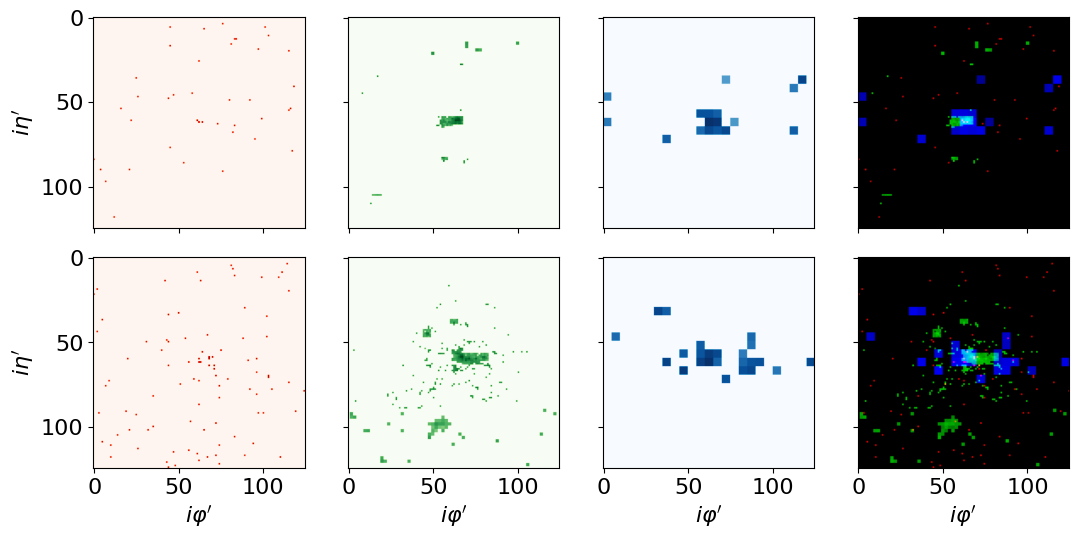

In [6]:
plot_image([q_one, g_one], 'one.pdf')

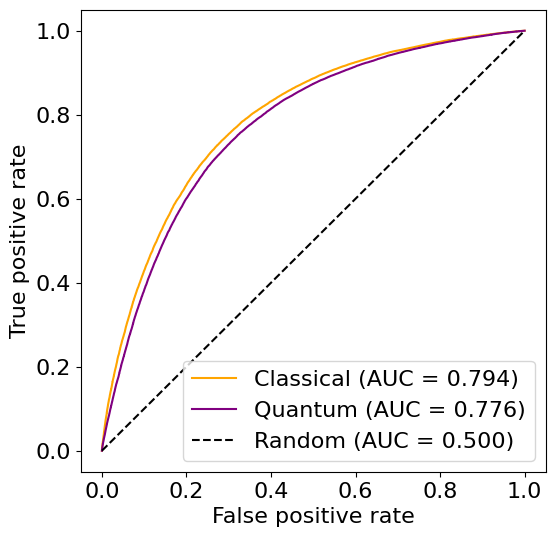

In [9]:
import pickle

with open('../classical/qg_pr.pkl', 'rb') as f:
    classical_fpr, classical_tpr, classical_auc = pickle.load(f)

with open('../quantum/qg_pr.pkl', 'rb') as f:
    quantum_fpr, quantum_tpr, quantum_auc = pickle.load(f)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(classical_fpr, classical_tpr, label=f'Classical (AUC = {classical_auc:.3f})', color='orange')
ax.plot(quantum_fpr, quantum_tpr, label=f'Quantum (AUC = {quantum_auc:.3f})', color='purple')
ax.plot([0, 1], [0, 1], label=f'Random (AUC = 0.500)', color='black', linestyle='--')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend()